In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from MySQLdb import connect
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

conn = connect(
    host="140.112.174.26",
    db="ijv",
    user="md703",
    passwd="MD703"
)
df = pd.read_sql("SELECT * FROM ijv_ann_2", con=conn)
len(df)

531600

In [2]:
len(set(df["idx"].tolist()))

1266

In [3]:
num = len(df)//3200
num

166

In [4]:
df.iloc[:, -3] = np.log(df.iloc[:, -3])

In [5]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.spec_layer = nn.Linear(20, 64)
        self.bn_spec = nn.BatchNorm1d(64)
        self.geo_layer = nn.Linear(7, 64)
        self.bn_geo = nn.BatchNorm1d(64)
        
#         self.fc1 = nn.Linear(64, 128)
#         self.bn1 = nn.BatchNorm1d(128)
#         self.fc2 = nn.Linear(128, 256)
#         self.bn2 = nn.BatchNorm1d(256)
#         self.fc3 = nn.Linear(256, 1)
        self.fc = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ELU(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ELU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ELU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ELU(),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ELU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ELU(),
            nn.Linear(256, 1)
        )
    
    def forward(self, spec, geo):
        spec = self.spec_layer(spec)
        spec = self.bn_spec(spec)
        spec = nn.ELU()(spec)
        
        geo = self.geo_layer(geo)
        geo = self.bn_geo(geo)
        geo = nn.ELU()(geo)
        
#         out = self.fc1(spec + geo)
#         out = self.bn1(out)
#         out = torch.relu(out)
        
#         out = self.fc2(out)
#         out = self.bn2(out)
#         out = torch.relu(out)
#         out = self.fc3(out) * 1e-9

        out = self.fc(spec + geo)
#         out = torch.clamp(out, min=0)
        
        
        return out

In [6]:
class SpecData(Dataset):
    def __init__(self, df, aug=True):
        self.df = df.values[:, 2:]
#         self.df = df
        self.aug = aug

    def __getitem__(self, idx):
        # 取最後三個(20mm, 24mm, 28mm的reflectance)
#         spec = self.df.iloc[idx][-3].astype(np.float)
#         spec = torch.tensor(np.expand_dims(spec, 0)).float()
        
#         geo = self.df.iloc[idx][-10:-3].astype(np.float).values
#         geo = torch.tensor(geo).float()
        
#         param = self.df.iloc[idx][2:22].astype(np.float).values
#         param = torch.tensor(param).float()
        
        spec = np.asarray([self.df[idx, -3]]).astype(np.float)
        geo = self.df[idx, -10:-3].astype(np.float)
        param = self.df[idx, 0:20].astype(np.float)
        
        if self.aug:
            geo *= (1+0.005*(2*np.random.rand()-1))
            param *= (1+0.005*(2*np.random.rand()-1))
        
        return spec, geo, param
    
    
    
    def __len__(self):
#         return len(self.df)
        return self.df.shape[0]

In [ ]:
model = Model()
model.to(device)
loss_func = nn.MSELoss()
# loss_func = RMSP
# loss_func = nn.CrossEntropyLoss()

In [11]:
optimizer = optim.Adam(lr=1e-5, params=model.parameters(), betas=(0.9, 0.999))
# optimizer = optim.SGD(lr=1e-6, params=model.parameters())
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [8]:
df = df.sample(frac=1)
train_set = SpecData(df[:-5000], True)
trainloader = DataLoader(train_set, batch_size=32,
                        shuffle=True, num_workers=0)
valid_set = SpecData(df[-5000:], False)
validloader = DataLoader(valid_set, batch_size=2500,
                        shuffle=True, num_workers=0)

In [9]:
lr_list = []
train_loss_list = []
valid_loss_list = []

In [15]:
for epoch in range(10000):
    train_loss_ = []
    valid_loss_ = []
    
    for i, (spec, geo, param) in enumerate(trainloader):
        spec, geo, param = torch.tensor(spec).float(), torch.tensor(geo).float(), torch.tensor(param).float()
        spec, geo, param = spec.to(device), geo.to(device), param.to(device)
        optimizer.zero_grad()
        predict = model(param, geo)
        loss = loss_func(predict, spec)
        loss.backward()
        optimizer.step()
        train_loss_ += [float(loss.data)]
        if i % 100 == 0:
            train_loss_list += [np.mean(train_loss_)]
            train_loss_ = []
            lr_list += [optimizer.param_groups[0]["lr"]]
    
            model.eval()
            for j, (_spec, geo, param) in enumerate(validloader):
                _spec, geo, param = torch.tensor(_spec).float(), torch.tensor(geo).float(), torch.tensor(param).float()
                
                _spec, geo, param = _spec.to(device), geo.to(device), param.to(device)
                _predict = model(param, geo)
                _loss = loss_func(_predict, _spec)

                valid_loss_ += [float(_loss.data)]
            model.train()
            valid_loss_list += [np.mean(valid_loss_)]
            valid_loss_ = []
    
    
    if epoch % 1 == 0:
            print("epoch: {} | train: {} | valid: {}".format(
                epoch, train_loss_list[-1], valid_loss_list[-1]),
                 )
            print("{}\n{}".format(torch.exp(spec[0:5]), torch.exp(predict[0:5])))
#             print("{}\n{}".format(spec[0:5]*std+mean, predict[0:5]*std+mean))

#         print(predict)
#         print(param)
#     scheduler.step(loss)

/home/md703/toast/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/md703/toast/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 0 | train: 0.10447678707540035 | valid: 0.48480625450611115
tensor([[1.1780e-07],
        [9.2137e-09],
        [1.1255e-08],
        [7.8582e-08],
        [1.3659e-08]], device='cuda:0')
tensor([[3.4293e-08],
        [1.0478e-08],
        [3.4324e-09],
        [4.2732e-08],
        [6.3698e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1 | train: 0.11356405440717936 | valid: 0.3677351027727127
tensor([[1.2441e-07],
        [4.8689e-08],
        [1.1917e-08],
        [2.0769e-07],
        [8.7216e-09]], device='cuda:0')
tensor([[1.2386e-07],
        [3.1448e-08],
        [1.3043e-08],
        [1.3697e-07],
        [7.4767e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2 | train: 0.10533508595079183 | valid: 0.3948180079460144
tensor([[4.8118e-08],
        [3.5095e-09],
        [3.3127e-08],
        [5.9760e-10],
        [1.6840e-09]], device='cuda:0')
tensor([[5.5336e-09],
        [8.7176e-10],
        [6.2371e-09],
        [5.9034e-10],
        [4.9792e-11]], devi

epoch: 24 | train: 0.10434807632118463 | valid: 0.38759855926036835
tensor([[3.0241e-08],
        [3.0295e-08],
        [1.4147e-08],
        [1.3837e-07],
        [9.2060e-08]], device='cuda:0')
tensor([[6.1219e-09],
        [3.0508e-08],
        [1.2556e-08],
        [1.2207e-07],
        [6.3218e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 25 | train: 0.11357861589640379 | valid: 0.3125137686729431
tensor([[2.0833e-08],
        [1.0974e-09],
        [2.8069e-08],
        [9.8459e-11],
        [5.4637e-08]], device='cuda:0')
tensor([[3.0050e-08],
        [8.8234e-10],
        [2.3134e-08],
        [5.5529e-11],
        [1.7273e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 26 | train: 0.1067977680079639 | valid: 0.390206441283226
tensor([[3.5644e-13],
        [5.5043e-11],
        [5.0098e-08],
        [1.1805e-09],
        [6.9696e-08]], device='cuda:0')
tensor([[4.3256e-13],
        [1.0199e-10],
        [6.6278e-08],
        [2.0360e-09],
        [6.5286e-08]], dev

epoch: 48 | train: 0.10803396858274937 | valid: 0.4458561986684799
tensor([[1.5737e-09],
        [3.0508e-08],
        [8.8413e-07],
        [1.1967e-09],
        [1.9126e-07]], device='cuda:0')
tensor([[1.9214e-10],
        [8.4903e-09],
        [3.7665e-08],
        [1.1000e-09],
        [1.0889e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 49 | train: 0.10710018966346979 | valid: 0.3267516493797302
tensor([[5.2584e-12],
        [2.0326e-08],
        [1.4254e-07],
        [5.0803e-08],
        [1.4387e-07]], device='cuda:0')
tensor([[9.7475e-12],
        [2.7959e-08],
        [5.8255e-08],
        [7.9653e-08],
        [2.8570e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 50 | train: 0.10518502220511436 | valid: 0.40058134496212006
tensor([[1.8293e-08],
        [4.4997e-09],
        [1.1532e-12],
        [5.1105e-08],
        [5.4864e-09]], device='cuda:0')
tensor([[1.5758e-08],
        [1.5747e-08],
        [3.7251e-12],
        [1.0656e-07],
        [2.9166e-09]], d

epoch: 72 | train: 0.1079295358248055 | valid: 0.4051894396543503
tensor([[2.4596e-08],
        [1.1657e-08],
        [6.7423e-10],
        [5.1785e-07],
        [4.2393e-09]], device='cuda:0')
tensor([[2.0479e-08],
        [8.1871e-09],
        [1.7883e-08],
        [1.0392e-07],
        [7.1995e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 73 | train: 0.10900348942726851 | valid: 0.4531414806842804
tensor([[1.1590e-07],
        [6.9678e-09],
        [1.1912e-12],
        [5.9199e-07],
        [2.6308e-10]], device='cuda:0')
tensor([[7.5204e-08],
        [8.9488e-09],
        [5.8871e-13],
        [6.9761e-07],
        [4.8718e-11]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 74 | train: 0.11829827569425105 | valid: 0.45025190711021423
tensor([[3.2394e-07],
        [3.1629e-12],
        [3.7783e-08],
        [2.5093e-08],
        [1.1353e-09]], device='cuda:0')
tensor([[5.1580e-07],
        [5.0339e-12],
        [2.2803e-08],
        [3.4077e-08],
        [1.4165e-10]], de

epoch: 96 | train: 0.10157234141603112 | valid: 0.4241306334733963
tensor([[1.3165e-08],
        [2.9274e-08],
        [9.5906e-10],
        [4.8737e-10],
        [1.5895e-07]], device='cuda:0')
tensor([[1.0266e-08],
        [1.8128e-08],
        [4.1828e-10],
        [6.3335e-11],
        [4.5368e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 97 | train: 0.11096271328628063 | valid: 0.5555631518363953
tensor([[1.4642e-07],
        [1.7496e-08],
        [1.9821e-09],
        [5.7427e-08],
        [3.5803e-08]], device='cuda:0')
tensor([[5.7357e-08],
        [1.8118e-08],
        [8.1432e-10],
        [2.6826e-08],
        [2.1299e-08]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 98 | train: 0.1092136112228036 | valid: 0.41192829608917236
tensor([[2.3270e-10],
        [1.2916e-12],
        [2.9028e-08],
        [4.6799e-08],
        [1.2151e-11]], device='cuda:0')
tensor([[1.7760e-09],
        [2.3438e-12],
        [9.0868e-08],
        [6.1739e-08],
        [2.7173e-10]], de

epoch: 120 | train: 0.10395635422319174 | valid: 0.35267654061317444
tensor([[1.2964e-08],
        [4.9725e-11],
        [2.4881e-09],
        [4.4428e-07],
        [3.6994e-11]], device='cuda:0')
tensor([[2.1749e-08],
        [9.9388e-11],
        [4.4416e-09],
        [6.5892e-07],
        [2.4815e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 121 | train: 0.10979505285620689 | valid: 0.3840258866548538
tensor([[2.0949e-08],
        [6.1085e-07],
        [5.2607e-09],
        [1.2869e-09],
        [2.6298e-10]], device='cuda:0')
tensor([[1.8058e-08],
        [4.0318e-07],
        [8.8251e-09],
        [7.1700e-10],
        [3.4694e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 122 | train: 0.10581838317215443 | valid: 0.400336354970932
tensor([[1.0861e-10],
        [1.0542e-09],
        [5.3595e-10],
        [1.2210e-08],
        [7.1976e-09]], device='cuda:0')
tensor([[4.6071e-10],
        [3.5189e-09],
        [1.1762e-09],
        [1.9463e-09],
        [5.2640e-09]],

epoch: 144 | train: 0.09575875703245401 | valid: 0.36503569781780243
tensor([[1.1345e-08],
        [1.0754e-09],
        [1.3753e-08],
        [1.6156e-12],
        [6.8310e-08]], device='cuda:0')
tensor([[4.3138e-08],
        [1.7159e-09],
        [2.0495e-08],
        [9.6107e-13],
        [1.1827e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 145 | train: 0.11951102718710899 | valid: 0.4902513325214386
tensor([[1.2404e-08],
        [3.5835e-09],
        [4.9681e-08],
        [1.8918e-08],
        [4.3372e-12]], device='cuda:0')
tensor([[4.5493e-09],
        [1.3597e-09],
        [1.6282e-08],
        [8.1020e-09],
        [1.8408e-12]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 146 | train: 0.09883909475058317 | valid: 0.4043009877204895
tensor([[3.9015e-08],
        [4.2417e-10],
        [4.7056e-08],
        [4.1890e-09],
        [6.0420e-08]], device='cuda:0')
tensor([[3.1660e-08],
        [4.2349e-10],
        [6.2495e-09],
        [4.1389e-09],
        [3.5745e-08]]

KeyboardInterrupt: 

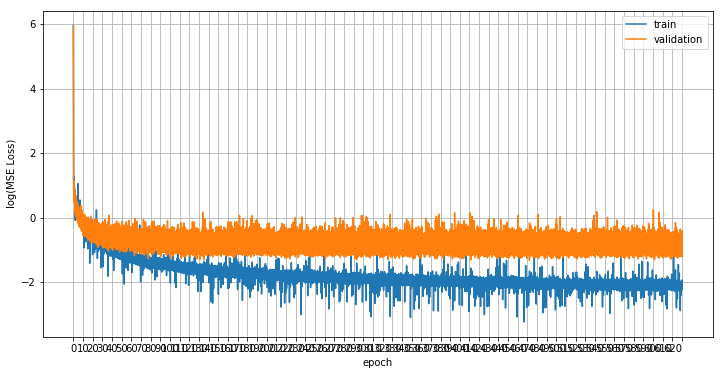

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(np.log(train_loss_list), label="train")
plt.plot(np.log(valid_loss_list), label="validation")
plt.xlabel("epoch")
plt.ylabel("log(MSE Loss)")
plt.xticks(
    [i for i in range(0, len(train_loss_list), num*10)], 
    [str(i*10) for i in range(len(train_loss_list)//(num*10))]
)
plt.legend()
plt.grid()
plt.show()

# plt.plot(np.log(aug_train_loss)[:70000])
# plt.plot(np.log(aug_valid_loss)[:70000])

In [ ]:
aug_train_loss = np.array(train_loss_list)
aug_valid_loss = np.array(valid_loss_list)

plt.plot(np.log(train_loss_list))
plt.plot(np.log(valid_loss_list))

In [ ]:
for epoch in range(10000):
    optimizer.zero_grad()
    pred = model(param, geo)
    loss = loss_func(pred, spec)
    loss.backward()
    optimizer.step()
    
    if epoch%100==0:
        print(float(loss))
        print(spec[:3])
        print(pred[:3])

## 分析

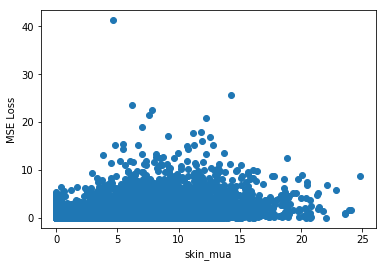

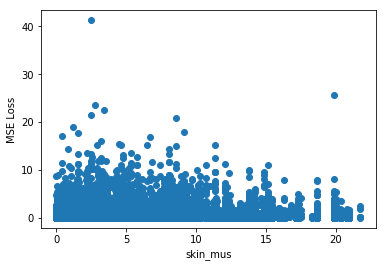

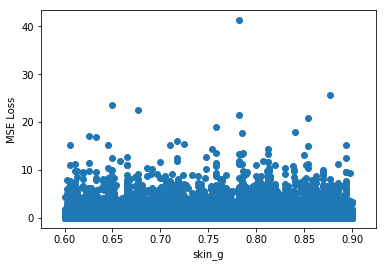

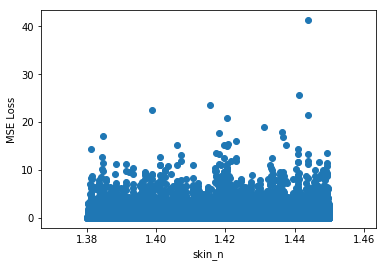

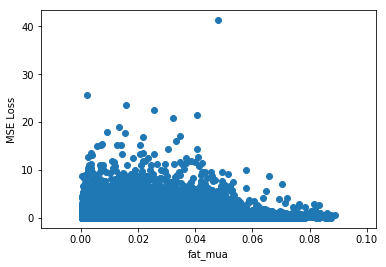

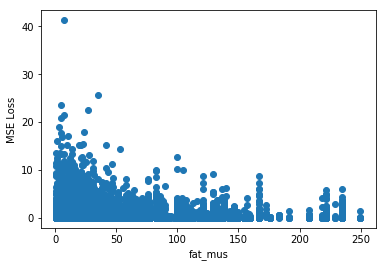

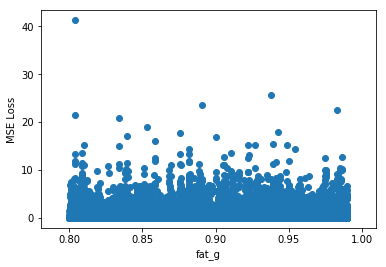

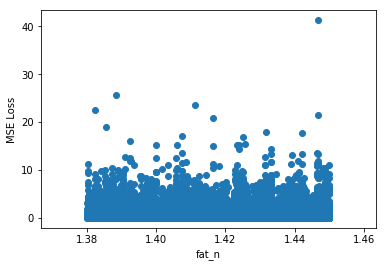

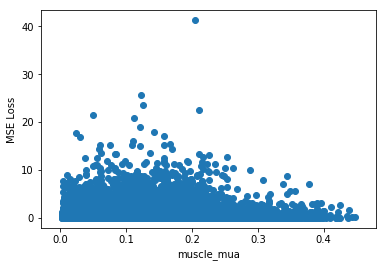

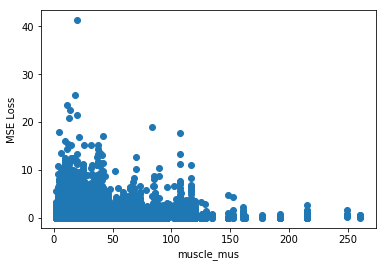

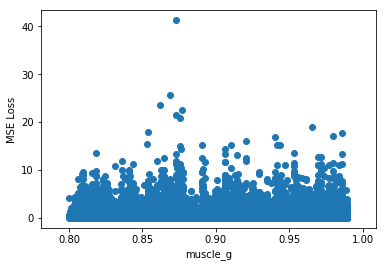

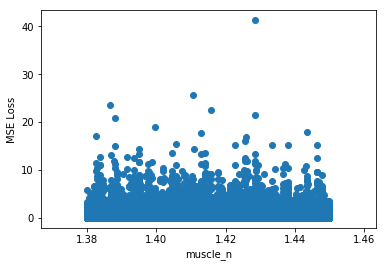

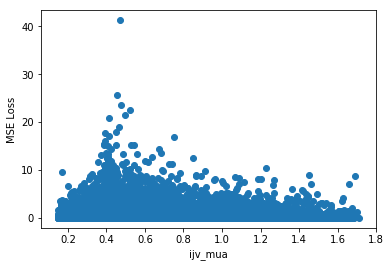

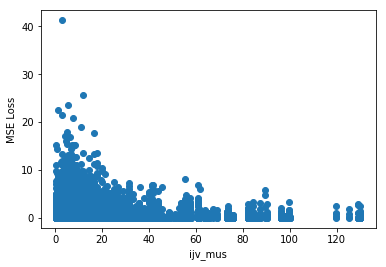

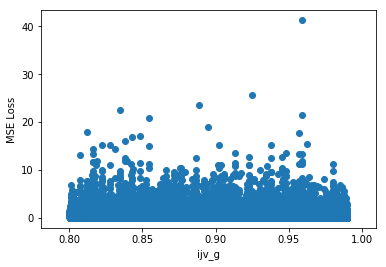

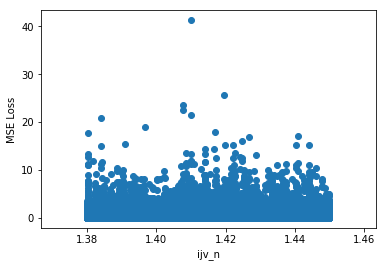

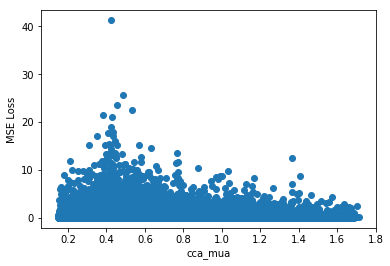

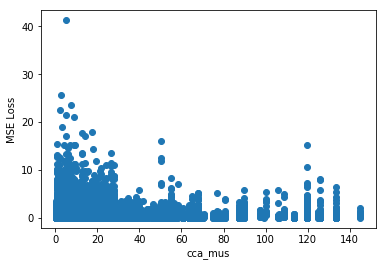

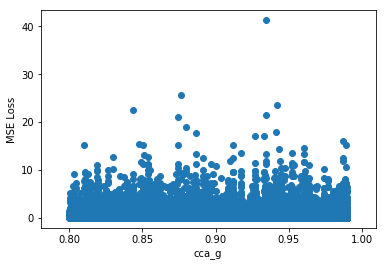

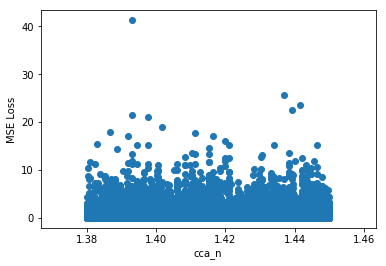

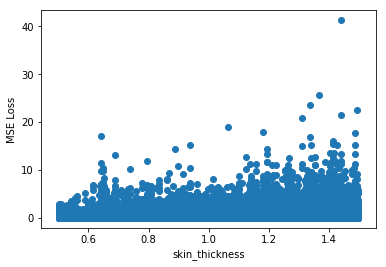

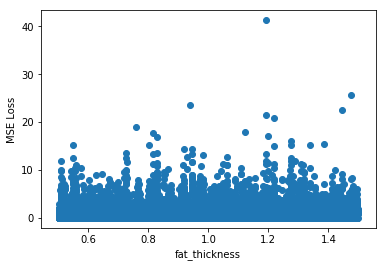

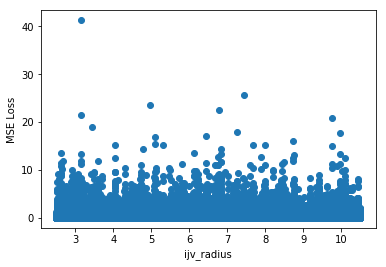

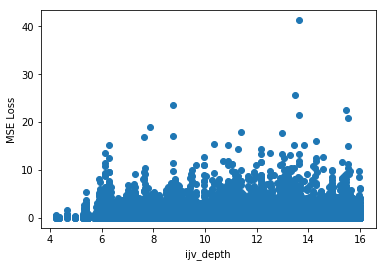

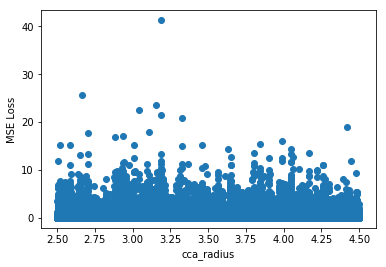

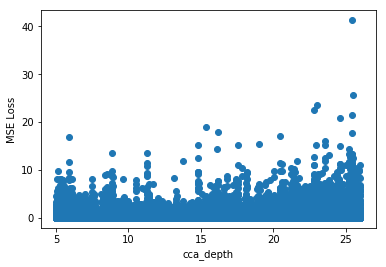

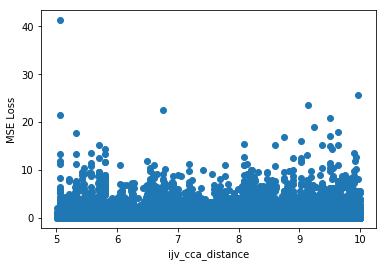

In [13]:
model.eval()

tmp = df.sample(frac=0.1)
pred = model(
    torch.tensor(tmp.values[:, 2:22].astype(np.float)).float().to(device), 
    torch.tensor(tmp.values[:, -10:-3].astype(np.float)).float().to(device)
)
loss = nn.MSELoss(reduction='none')(pred, torch.tensor(np.expand_dims(tmp.values[:, -3], 1).astype(np.float)).float().to(device))
tmp["loss"] = loss.detach().cpu().numpy()
model.train()

col = df.columns[2:-3]
for c in col:
#     tmp.sort_values(by=[c])

#     plt.title(c)
    plt.scatter(tmp[c].tolist(), tmp["loss"].tolist())
    plt.xlabel(c)
    plt.ylabel("MSE Loss")
    plt.show()

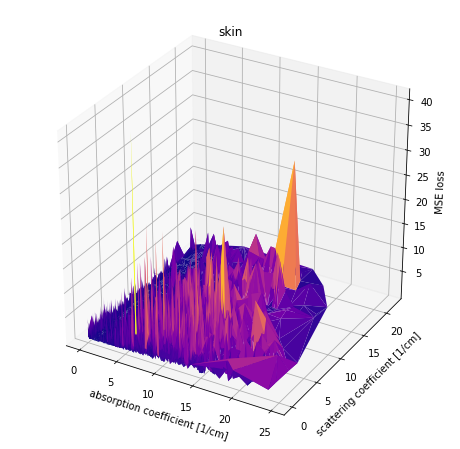

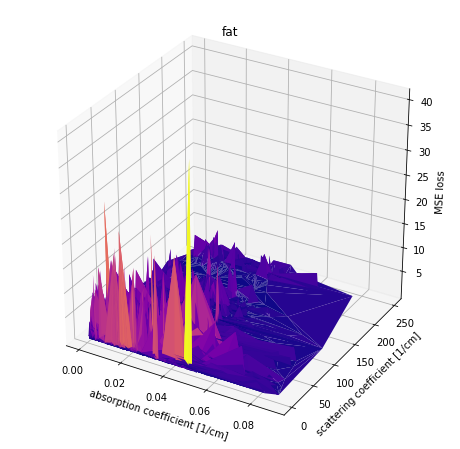

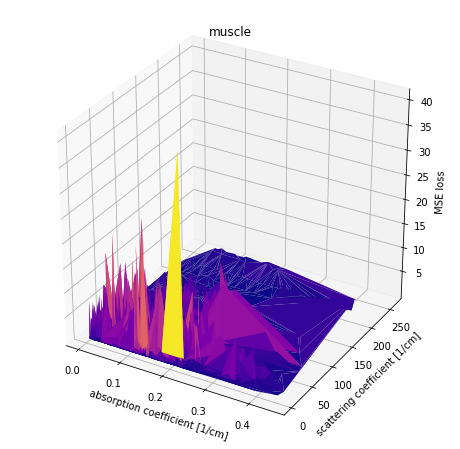

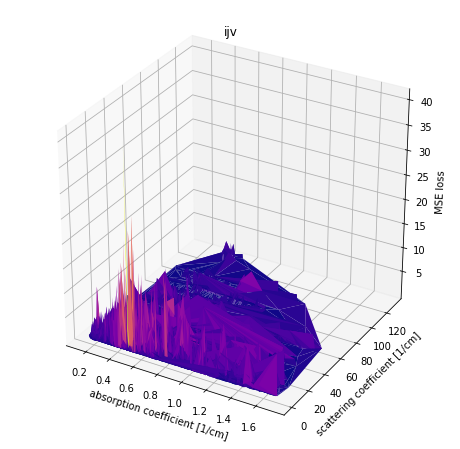

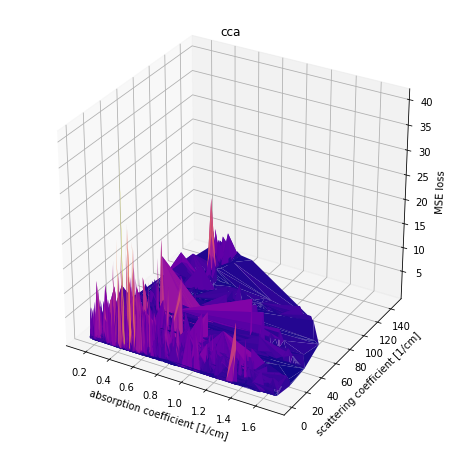

In [14]:
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d, Axes3D

fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection="3d")
surf = ax.plot_trisurf(tmp.skin_mua, tmp.skin_mus, tmp.loss, cmap=cm.plasma)
ax.set_title("skin")
ax.set_xlabel("absorption coefficient [1/cm]")
ax.set_ylabel("scattering coefficient [1/cm]")
ax.set_zlabel("MSE loss")
plt.show()

fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection="3d")
surf = ax.plot_trisurf(tmp.fat_mua, tmp.fat_mus, tmp.loss, cmap=cm.plasma)
ax.set_title("fat")
ax.set_xlabel("absorption coefficient [1/cm]")
ax.set_ylabel("scattering coefficient [1/cm]")
ax.set_zlabel("MSE loss")
plt.show()

fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection="3d")
surf = ax.plot_trisurf(tmp.muscle_mua, tmp.muscle_mus, tmp.loss, cmap=cm.plasma)
ax.set_title("muscle")
ax.set_xlabel("absorption coefficient [1/cm]")
ax.set_ylabel("scattering coefficient [1/cm]")
ax.set_zlabel("MSE loss")
plt.show()

fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection="3d")
surf = ax.plot_trisurf(tmp.ijv_mua, tmp.ijv_mus, tmp.loss, cmap=cm.plasma)
ax.set_title("ijv")
ax.set_xlabel("absorption coefficient [1/cm]")
ax.set_ylabel("scattering coefficient [1/cm]")
ax.set_zlabel("MSE loss")
plt.show()

fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection="3d")
surf = ax.plot_trisurf(tmp.cca_mua, tmp.cca_mus, tmp.loss, cmap=cm.plasma)
ax.set_title("cca")
ax.set_xlabel("absorption coefficient [1/cm]")
ax.set_ylabel("scattering coefficient [1/cm]")
ax.set_zlabel("MSE loss")
plt.show()